In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

#font_location = r'Fonts\H2HDRM.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#plt.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [7]:
rev_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [9]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


### 내가 관심있는 상권을 검색

In [8]:
mapo_rev_2020 = rev_2020.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2019 = rev_2019.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2018 = rev_2018.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2017 = rev_2017.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2016 = rev_2016.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2015 = rev_2015.groupby(['상권_코드']).get_group((1001182))

mapo_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6799,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300036,조명용품,142747635,4676,...,0,2339,669,0,337,1836,335,166,335,11
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6802,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300031,가구,1212000000,1239,...,0,776,414,0,66,344,281,367,132,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [9]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [10]:
common_sc_1001182 = set(return_com_sc_by_year_and_ba(2020,1001182)) &\
set(return_com_sc_by_year_and_ba(2019,1001182)) &\
set(return_com_sc_by_year_and_ba(2018,1001182)) &\
set(return_com_sc_by_year_and_ba(2017,1001182)) &\
set(return_com_sc_by_year_and_ba(2016,1001182)) &\
set(return_com_sc_by_year_and_ba(2015,1001182))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [12]:
len(common_sc_1001182)

44

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [13]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

mapo_new_rev_2020 = mapo_rev_2020.loc[mapo_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2019 = mapo_rev_2019.loc[mapo_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2018 = mapo_rev_2018.loc[mapo_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2017 = mapo_rev_2017.loc[mapo_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2016 = mapo_rev_2016.loc[mapo_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2015 = mapo_rev_2015.loc[mapo_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001182)]

In [14]:
# print(gangnam_rev_2020.shape)
# print(gangnam_new_rev_2020.shape)
mapo_new_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6803,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
6805,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [75]:
mapo_all_rev = mapo_new_rev_2020.append(mapo_new_rev_2019, ignore_index=True)\
.append(mapo_new_rev_2018, ignore_index=True)\
.append(mapo_new_rev_2017, ignore_index=True)\
.append(mapo_new_rev_2016, ignore_index=True)\
.append(mapo_new_rev_2015, ignore_index=True)

mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
1,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
2,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
3,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
4,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200028,미용실,10950069634,179482,...,9391,95489,82854,3744,80034,55705,22305,13330,3226,165
964,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200016,당구장,266556478,19927,...,6479,15214,4643,1687,12353,2933,1670,1015,199,21
965,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100006,패스트푸드점,4621384109,376994,...,59924,188933,170841,22938,217234,61416,32309,22405,3492,60
966,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,5142497778,479400,...,43131,139728,322885,20630,235143,113636,54546,30532,8132,71


### 쓸모없는 열은 제외한다.

In [76]:
mapo_all_rev = mapo_all_rev.groupby(['서비스_업종_코드']).get_group(('CS300022'))
mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
5,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,11379527855,344826,...,39750,60062,284282,15921,210620,57299,27190,25688,7625,176
49,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,12991505941,500153,...,75019,78386,421568,28452,314630,70071,40758,36432,9610,179
119,2019,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,18607834077,937507,...,151993,145043,792160,65938,571164,121666,90483,69577,18375,173
171,2019,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,14486991462,653925,...,108324,110985,542413,41873,386137,94268,63268,47407,20446,174
194,2019,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,17076223402,822553,...,137186,132702,689695,63317,475483,112997,84481,58043,28077,179
254,2019,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,16178154320,731871,...,130720,110555,620721,70948,420550,84286,65434,48815,41241,169
264,2018,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,20582708008,1123570,...,191147,155315,960840,109526,721000,127696,81210,63313,13417,188
339,2018,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,19366102563,1015991,...,185781,147047,860911,84217,633519,132839,82208,59597,15583,183
371,2018,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,18201391328,997719,...,187174,149219,840827,89867,617679,123080,85591,60626,13209,181
409,2018,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,23243161708,1227329,...,219037,227556,989817,110042,742197,168766,100806,76456,19120,181


In [77]:
mapo_all_rev = mapo_all_rev.drop(['상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드_명'], axis=1)
mapo_all_rev

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
5,2020,2,CS300022,11379527855,344826,67,33,12,12,13,...,39750,60062,284282,15921,210620,57299,27190,25688,7625,176
49,2020,1,CS300022,12991505941,500153,69,31,12,13,14,...,75019,78386,421568,28452,314630,70071,40758,36432,9610,179
119,2019,1,CS300022,18607834077,937507,67,33,10,14,13,...,151993,145043,792160,65938,571164,121666,90483,69577,18375,173
171,2019,2,CS300022,14486991462,653925,67,33,12,12,13,...,108324,110985,542413,41873,386137,94268,63268,47407,20446,174
194,2019,3,CS300022,17076223402,822553,68,32,15,12,13,...,137186,132702,689695,63317,475483,112997,84481,58043,28077,179
254,2019,4,CS300022,16178154320,731871,68,32,11,16,13,...,130720,110555,620721,70948,420550,84286,65434,48815,41241,169
264,2018,1,CS300022,20582708008,1123570,66,34,13,13,13,...,191147,155315,960840,109526,721000,127696,81210,63313,13417,188
339,2018,2,CS300022,19366102563,1015991,65,35,11,12,12,...,185781,147047,860911,84217,633519,132839,82208,59597,15583,183
371,2018,3,CS300022,18201391328,997719,67,33,12,12,14,...,187174,149219,840827,89867,617679,123080,85591,60626,13209,181
409,2018,4,CS300022,23243161708,1227329,67,33,14,11,13,...,219037,227556,989817,110042,742197,168766,100806,76456,19120,181


In [36]:
# mapo_all_rev.to_csv(r'mapo_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [94]:
fr_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [95]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [96]:
mapo_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((1001182))

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16815,16815,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,0
16816,16816,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300041,예술품,0
16817,16817,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300040,재생용품 판매점,0
16818,16818,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300038,자동차부품,0
16819,16819,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300037,중고차판매,0
...,...,...,...,...,...,...,...,...,...,...
109283,109283,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,8
109284,109284,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,4
109285,109285,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,6
109286,109286,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,3


In [97]:
mapo_fr_2020 = mapo_fr_2020.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2019 = mapo_fr_2019.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2018 = mapo_fr_2018.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2017 = mapo_fr_2017.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2016 = mapo_fr_2016.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2015 = mapo_fr_2015.groupby(['서비스_업종_코드']).get_group('CS300022')

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16833,16833,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
109209,109209,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6


In [98]:
mapo_new_fr= mapo_fr_2020.append(mapo_fr_2019, ignore_index=True)\
.append(mapo_fr_2018, ignore_index=True)\
.append(mapo_fr_2017, ignore_index=True)\
.append(mapo_fr_2016, ignore_index=True)\
.append(mapo_fr_2015, ignore_index=True)

mapo_new_fr

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,16833,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
1,109209,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6
2,15,2019,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,8
3,136730,2019,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
4,201855,2019,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
5,294173,2019,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,4
6,28261,2018,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
7,90439,2018,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6
8,265441,2018,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
9,310693,2018,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3


In [99]:
mapo_new_fr=mapo_new_fr.drop(['Unnamed: 0','기준_년_코드','기준_분기_코드','상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드','서비스_업종_코드_명'], axis=1)
mapo_new_fr

,폐업_률
0,2
1,6
2,8
3,2
4,3
5,4
6,3
7,6
8,3
9,3


### 인풋 데이터의 서비스업종과 아웃풋 데이터를 합친다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [100]:
mapo_all_rev = mapo_all_rev.reset_index(drop=True, inplace=False)
mapo_new_fr = mapo_new_fr.reset_index(drop=True, inplace=False)

mapo = pd.concat( [mapo_all_rev, mapo_new_fr],axis=1) 
mapo

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS300022,11379527855,344826,67,33,12,12,13,...,60062,284282,15921,210620,57299,27190,25688,7625,176,2
1,2020,1,CS300022,12991505941,500153,69,31,12,13,14,...,78386,421568,28452,314630,70071,40758,36432,9610,179,6
2,2019,1,CS300022,18607834077,937507,67,33,10,14,13,...,145043,792160,65938,571164,121666,90483,69577,18375,173,8
3,2019,2,CS300022,14486991462,653925,67,33,12,12,13,...,110985,542413,41873,386137,94268,63268,47407,20446,174,2
4,2019,3,CS300022,17076223402,822553,68,32,15,12,13,...,132702,689695,63317,475483,112997,84481,58043,28077,179,3
5,2019,4,CS300022,16178154320,731871,68,32,11,16,13,...,110555,620721,70948,420550,84286,65434,48815,41241,169,4
6,2018,1,CS300022,20582708008,1123570,66,34,13,13,13,...,155315,960840,109526,721000,127696,81210,63313,13417,188,3
7,2018,2,CS300022,19366102563,1015991,65,35,11,12,12,...,147047,860911,84217,633519,132839,82208,59597,15583,183,6
8,2018,3,CS300022,18201391328,997719,67,33,12,12,14,...,149219,840827,89867,617679,123080,85591,60626,13209,181,3
9,2018,4,CS300022,23243161708,1227329,67,33,14,11,13,...,227556,989817,110042,742197,168766,100806,76456,19120,181,3


In [101]:
mapo_col=mapo.columns
mapo_col

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [102]:
len(mapo_col)

76

In [115]:
from sklearn import preprocessing
for i in range(3,75):
    x = mapo[mapo_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    mapo[mapo_col[i]] = pd.DataFrame(x_scaled)

In [116]:
all_data_in = mapo.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,CS300022,0.00,0.00,0.33,0.67,0.40,0.20,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17
1,2020,1,CS300022,0.10,0.14,0.67,0.33,0.40,0.40,0.75,...,0.16,0.11,0.15,0.10,0.15,0.10,0.17,0.21,0.06,0.24
2,2019,1,CS300022,0.44,0.55,0.33,0.67,0.00,0.60,0.50,...,0.50,0.51,0.54,0.41,0.51,0.48,0.81,0.84,0.32,0.10
3,2019,2,CS300022,0.19,0.28,0.33,0.67,0.40,0.20,0.50,...,0.30,0.30,0.28,0.21,0.25,0.28,0.46,0.42,0.38,0.12
4,2019,3,CS300022,0.34,0.44,0.50,0.50,1.00,0.20,0.50,...,0.43,0.43,0.43,0.39,0.37,0.42,0.73,0.62,0.61,0.24
5,2019,4,CS300022,0.29,0.36,0.50,0.50,0.20,1.00,0.50,...,0.40,0.30,0.36,0.45,0.30,0.20,0.49,0.44,1.00,0.00
6,2018,1,CS300022,0.56,0.72,0.17,0.83,0.60,0.40,0.50,...,0.67,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45
7,2018,2,CS300022,0.48,0.62,0.00,1.00,0.20,0.20,0.25,...,0.65,0.52,0.61,0.56,0.60,0.57,0.70,0.65,0.24,0.33
8,2018,3,CS300022,0.41,0.60,0.33,0.67,0.40,0.20,0.75,...,0.65,0.53,0.59,0.60,0.57,0.49,0.75,0.67,0.17,0.29
9,2018,4,CS300022,0.72,0.81,0.33,0.67,0.80,0.00,0.50,...,0.80,1.00,0.75,0.77,0.75,0.84,0.94,0.97,0.34,0.29


### 시계열 인풋데이터 만들기

In [136]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-2'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-1'))
    return _test

In [137]:
x_predict_2020_2 = four_season_data_in(all_data_in,2019,2,2019,3,2019,4,2020,1)
x_predict_2020_2

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS300022,0.19,0.28,0.33,0.67,0.40,0.20,0.50,0.00,0.40,...,0.16,0.11,0.15,0.10,0.15,0.10,0.17,0.21,0.06,0.24


### 시계열 아웃풋 데이터 만들기

In [138]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [139]:
y_predict_2020_2 = four_season_data_out(mapo,2020,2)
y_predict_2020_2

,폐업_률
0,2


### 시계열 데이터 합치기 

In [140]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(list_season)

[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [141]:
for i in range(0,18):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][0],list_season[i][1],
                                                                                                                  list_season[i+1][0],list_season[i+1][1],
                                                                                                                  list_season[i+2][0],list_season[i+2][1],
                                                                                                                  list_season[i+3][0],list_season[i+3][1]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_out(mapo,
                                                                                                                 list_season[i+4][0],list_season[i+4][1])

In [166]:
# df 를 vertically concat 하기 위해 append 함
x_in = pd.DataFrame(columns=x_predict_2020_2.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2.columns)
for i in range(0,18):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
x_in=x_in.drop(['서비스_업종_코드'], axis=1)
x_in = x_in.reset_index(drop=True, inplace=False)
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.48,0.50,0.33,0.67,0.60,0.40,0.00,0.00,0.60,0.80,...,0.68,0.54,0.63,0.61,0.60,0.68,0.73,0.59,0.10,0.90
1,0.56,0.54,0.83,0.17,0.60,0.40,0.75,0.00,0.80,0.40,...,0.91,0.76,0.96,0.84,0.94,0.96,0.92,0.94,0.12,0.90
2,0.61,0.60,1.00,0.00,0.40,0.40,1.00,0.25,0.40,0.20,...,0.95,0.74,0.93,0.74,0.91,1.00,0.92,0.90,0.14,1.00
3,0.66,0.64,0.67,0.33,0.20,0.60,0.00,1.00,0.40,0.60,...,1.00,0.77,0.98,0.92,0.97,0.87,1.00,0.92,0.15,0.79
4,0.93,0.97,0.00,1.00,0.00,0.20,0.25,0.00,0.40,1.00,...,0.90,0.84,0.90,0.95,0.88,0.83,0.99,0.91,0.16,0.69
5,0.89,0.93,0.33,0.67,0.20,0.00,0.25,0.50,1.00,0.80,...,0.89,0.83,1.00,1.00,1.00,0.86,0.92,1.00,0.16,0.62
6,0.88,0.98,0.50,0.50,0.40,0.20,0.50,0.00,0.80,0.60,...,0.96,0.81,0.97,0.93,0.96,0.89,0.99,0.96,0.20,0.74
7,1.00,0.92,0.17,1.00,0.40,0.40,0.25,0.00,0.40,1.00,...,0.92,0.71,0.92,0.98,0.90,0.67,0.98,0.92,0.14,0.55
8,0.95,1.00,0.67,0.33,0.40,1.00,0.50,0.25,0.20,0.00,...,0.78,0.65,0.76,0.93,0.75,0.54,0.86,0.71,0.13,0.48
9,0.77,0.97,0.33,0.83,0.40,0.20,0.25,0.25,0.60,0.80,...,0.67,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45


In [167]:
x_out = x_out.reset_index(drop=True, inplace=False)
x_out

,폐업_률
0,4
1,4
2,7
3,3
4,5
5,5
6,5
7,2
8,3
9,6


In [172]:
x_out['폐업_률'] = pd.to_numeric(x_out['폐업_률'])
x_out

,폐업_률
0,4
1,4
2,7
3,3
4,5
5,5
6,5
7,2
8,3
9,6


In [173]:
x = pd.concat([x_in,x_out], axis=1)
x

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.48,0.50,0.33,0.67,0.60,0.40,0.00,0.00,0.60,0.80,...,0.54,0.63,0.61,0.60,0.68,0.73,0.59,0.10,0.90,4
1,0.56,0.54,0.83,0.17,0.60,0.40,0.75,0.00,0.80,0.40,...,0.76,0.96,0.84,0.94,0.96,0.92,0.94,0.12,0.90,4
2,0.61,0.60,1.00,0.00,0.40,0.40,1.00,0.25,0.40,0.20,...,0.74,0.93,0.74,0.91,1.00,0.92,0.90,0.14,1.00,7
3,0.66,0.64,0.67,0.33,0.20,0.60,0.00,1.00,0.40,0.60,...,0.77,0.98,0.92,0.97,0.87,1.00,0.92,0.15,0.79,3
4,0.93,0.97,0.00,1.00,0.00,0.20,0.25,0.00,0.40,1.00,...,0.84,0.90,0.95,0.88,0.83,0.99,0.91,0.16,0.69,5
5,0.89,0.93,0.33,0.67,0.20,0.00,0.25,0.50,1.00,0.80,...,0.83,1.00,1.00,1.00,0.86,0.92,1.00,0.16,0.62,5
6,0.88,0.98,0.50,0.50,0.40,0.20,0.50,0.00,0.80,0.60,...,0.81,0.97,0.93,0.96,0.89,0.99,0.96,0.20,0.74,5
7,1.00,0.92,0.17,1.00,0.40,0.40,0.25,0.00,0.40,1.00,...,0.71,0.92,0.98,0.90,0.67,0.98,0.92,0.14,0.55,2
8,0.95,1.00,0.67,0.33,0.40,1.00,0.50,0.25,0.20,0.00,...,0.65,0.76,0.93,0.75,0.54,0.86,0.71,0.13,0.48,3
9,0.77,0.97,0.33,0.83,0.40,0.20,0.25,0.25,0.60,0.80,...,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45,6


In [198]:
#데이터 확인목적
x.to_csv(r'mapo_dataset.csv', encoding = 'cp949')

In [174]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [188]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=5000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:3.56712
[1]	validation_0-rmse:3.56377
[2]	validation_0-rmse:3.55970
[3]	validation_0-rmse:3.55591
[4]	validation_0-rmse:3.55219
[5]	validation_0-rmse:3.54929
[6]	validation_0-rmse:3.54542
[7]	validation_0-rmse:3.54211
[8]	validation_0-rmse:3.53980
[9]	validation_0-rmse:3.53655
[10]	validation_0-rmse:3.53367
[11]	validation_0-rmse:3.53014
[12]	validation_0-rmse:3.52657
[13]	validation_0-rmse:3.52349
[14]	validation_0-rmse:3.52034
[15]	validation_0-rmse:3.51703
[16]	validation_0-rmse:3.51343
[17]	validation_0-rmse:3.51031
[18]	validation_0-rmse:3.50653
[19]	validation_0-rmse:3.50308
[20]	validation_0-rmse:3.49986
[21]	validation_0-rmse:3.49684
[22]	validation_0-rmse:3.49466
[23]	validation_0-rmse:3.49022
[24]	validation_0-rmse:3.48646
[25]	validation_0-rmse:3.48440
[26]	validation_0-rmse:3.48273
[27]	validation_0-rmse:3.47917
[28]	validation_0-rmse:3.47655
[29]	validation_0-rmse:3.47341
[30]	validation_0-rmse:3.47063
[31]	validation_0-rmse:3.46615
[32]	validation_0-

[260]	validation_0-rmse:2.80807
[261]	validation_0-rmse:2.80610
[262]	validation_0-rmse:2.80307
[263]	validation_0-rmse:2.79998
[264]	validation_0-rmse:2.79695
[265]	validation_0-rmse:2.79444
[266]	validation_0-rmse:2.79123
[267]	validation_0-rmse:2.78837
[268]	validation_0-rmse:2.78673
[269]	validation_0-rmse:2.78392
[270]	validation_0-rmse:2.78088
[271]	validation_0-rmse:2.77955
[272]	validation_0-rmse:2.77687
[273]	validation_0-rmse:2.77454
[274]	validation_0-rmse:2.77184
[275]	validation_0-rmse:2.76886
[276]	validation_0-rmse:2.76599
[277]	validation_0-rmse:2.76222
[278]	validation_0-rmse:2.76010
[279]	validation_0-rmse:2.75877
[280]	validation_0-rmse:2.75593
[281]	validation_0-rmse:2.75311
[282]	validation_0-rmse:2.74917
[283]	validation_0-rmse:2.74611
[284]	validation_0-rmse:2.74479
[285]	validation_0-rmse:2.74179
[286]	validation_0-rmse:2.73982
[287]	validation_0-rmse:2.73687
[288]	validation_0-rmse:2.73483
[289]	validation_0-rmse:2.73197
[290]	validation_0-rmse:2.73076
[291]	va

[517]	validation_0-rmse:2.18872
[518]	validation_0-rmse:2.18648
[519]	validation_0-rmse:2.18461
[520]	validation_0-rmse:2.18339
[521]	validation_0-rmse:2.18098
[522]	validation_0-rmse:2.17873
[523]	validation_0-rmse:2.17633
[524]	validation_0-rmse:2.17339
[525]	validation_0-rmse:2.17119
[526]	validation_0-rmse:2.16942
[527]	validation_0-rmse:2.16703
[528]	validation_0-rmse:2.16452
[529]	validation_0-rmse:2.16234
[530]	validation_0-rmse:2.15969
[531]	validation_0-rmse:2.15721
[532]	validation_0-rmse:2.15550
[533]	validation_0-rmse:2.15324
[534]	validation_0-rmse:2.15089
[535]	validation_0-rmse:2.14873
[536]	validation_0-rmse:2.14651
[537]	validation_0-rmse:2.14430
[538]	validation_0-rmse:2.14230
[539]	validation_0-rmse:2.14133
[540]	validation_0-rmse:2.13914
[541]	validation_0-rmse:2.13693
[542]	validation_0-rmse:2.13514
[543]	validation_0-rmse:2.13257
[544]	validation_0-rmse:2.13122
[545]	validation_0-rmse:2.12965
[546]	validation_0-rmse:2.12639
[547]	validation_0-rmse:2.12382
[548]	va

[774]	validation_0-rmse:1.68872
[775]	validation_0-rmse:1.68664
[776]	validation_0-rmse:1.68451
[777]	validation_0-rmse:1.68238
[778]	validation_0-rmse:1.68033
[779]	validation_0-rmse:1.67829
[780]	validation_0-rmse:1.67655
[781]	validation_0-rmse:1.67477
[782]	validation_0-rmse:1.67202
[783]	validation_0-rmse:1.66914
[784]	validation_0-rmse:1.66669
[785]	validation_0-rmse:1.66452
[786]	validation_0-rmse:1.66276
[787]	validation_0-rmse:1.66084
[788]	validation_0-rmse:1.65901
[789]	validation_0-rmse:1.65759
[790]	validation_0-rmse:1.65548
[791]	validation_0-rmse:1.65355
[792]	validation_0-rmse:1.65082
[793]	validation_0-rmse:1.65012
[794]	validation_0-rmse:1.64793
[795]	validation_0-rmse:1.64603
[796]	validation_0-rmse:1.64410
[797]	validation_0-rmse:1.64222
[798]	validation_0-rmse:1.64146
[799]	validation_0-rmse:1.63948
[800]	validation_0-rmse:1.63757
[801]	validation_0-rmse:1.63550
[802]	validation_0-rmse:1.63375
[803]	validation_0-rmse:1.63194
[804]	validation_0-rmse:1.62924
[805]	va

[1030]	validation_0-rmse:1.28611
[1031]	validation_0-rmse:1.28455
[1032]	validation_0-rmse:1.28300
[1033]	validation_0-rmse:1.28159
[1034]	validation_0-rmse:1.27994
[1035]	validation_0-rmse:1.27755
[1036]	validation_0-rmse:1.27698
[1037]	validation_0-rmse:1.27554
[1038]	validation_0-rmse:1.27536
[1039]	validation_0-rmse:1.27366
[1040]	validation_0-rmse:1.27204
[1041]	validation_0-rmse:1.27139
[1042]	validation_0-rmse:1.26967
[1043]	validation_0-rmse:1.26910
[1044]	validation_0-rmse:1.26772
[1045]	validation_0-rmse:1.26632
[1046]	validation_0-rmse:1.26547
[1047]	validation_0-rmse:1.26389
[1048]	validation_0-rmse:1.26213
[1049]	validation_0-rmse:1.26043
[1050]	validation_0-rmse:1.25892
[1051]	validation_0-rmse:1.25730
[1052]	validation_0-rmse:1.25558
[1053]	validation_0-rmse:1.25391
[1054]	validation_0-rmse:1.25281
[1055]	validation_0-rmse:1.25124
[1056]	validation_0-rmse:1.25063
[1057]	validation_0-rmse:1.25007
[1058]	validation_0-rmse:1.24914
[1059]	validation_0-rmse:1.24754
[1060]	val

[1279]	validation_0-rmse:0.97875
[1280]	validation_0-rmse:0.97711
[1281]	validation_0-rmse:0.97575
[1282]	validation_0-rmse:0.97441
[1283]	validation_0-rmse:0.97307
[1284]	validation_0-rmse:0.97294
[1285]	validation_0-rmse:0.97152
[1286]	validation_0-rmse:0.97084
[1287]	validation_0-rmse:0.96893
[1288]	validation_0-rmse:0.96765
[1289]	validation_0-rmse:0.96625
[1290]	validation_0-rmse:0.96613
[1291]	validation_0-rmse:0.96472
[1292]	validation_0-rmse:0.96460
[1293]	validation_0-rmse:0.96393
[1294]	validation_0-rmse:0.96308
[1295]	validation_0-rmse:0.96118
[1296]	validation_0-rmse:0.96051
[1297]	validation_0-rmse:0.95916
[1298]	validation_0-rmse:0.95788
[1299]	validation_0-rmse:0.95651
[1300]	validation_0-rmse:0.95624
[1301]	validation_0-rmse:0.95493
[1302]	validation_0-rmse:0.95319
[1303]	validation_0-rmse:0.95141
[1304]	validation_0-rmse:0.95011
[1305]	validation_0-rmse:0.94877
[1306]	validation_0-rmse:0.94749
[1307]	validation_0-rmse:0.94620
[1308]	validation_0-rmse:0.94503
[1309]	val

[1528]	validation_0-rmse:0.75241
[1529]	validation_0-rmse:0.75142
[1530]	validation_0-rmse:0.75101
[1531]	validation_0-rmse:0.75000
[1532]	validation_0-rmse:0.74901
[1533]	validation_0-rmse:0.74856
[1534]	validation_0-rmse:0.74755
[1535]	validation_0-rmse:0.74692
[1536]	validation_0-rmse:0.74611
[1537]	validation_0-rmse:0.74511
[1538]	validation_0-rmse:0.74483
[1539]	validation_0-rmse:0.74408
[1540]	validation_0-rmse:0.74366
[1541]	validation_0-rmse:0.74328
[1542]	validation_0-rmse:0.74254
[1543]	validation_0-rmse:0.74153
[1544]	validation_0-rmse:0.74058
[1545]	validation_0-rmse:0.73999
[1546]	validation_0-rmse:0.73900
[1547]	validation_0-rmse:0.73862
[1548]	validation_0-rmse:0.73758
[1549]	validation_0-rmse:0.73687
[1550]	validation_0-rmse:0.73593
[1551]	validation_0-rmse:0.73531
[1552]	validation_0-rmse:0.73465
[1553]	validation_0-rmse:0.73382
[1554]	validation_0-rmse:0.73347
[1555]	validation_0-rmse:0.73323
[1556]	validation_0-rmse:0.73253
[1557]	validation_0-rmse:0.73158
[1558]	val

[1777]	validation_0-rmse:0.60481
[1778]	validation_0-rmse:0.60440
[1779]	validation_0-rmse:0.60379
[1780]	validation_0-rmse:0.60338
[1781]	validation_0-rmse:0.60314
[1782]	validation_0-rmse:0.60260
[1783]	validation_0-rmse:0.60247
[1784]	validation_0-rmse:0.60224
[1785]	validation_0-rmse:0.60103
[1786]	validation_0-rmse:0.60095
[1787]	validation_0-rmse:0.60047
[1788]	validation_0-rmse:0.60011
[1789]	validation_0-rmse:0.59965
[1790]	validation_0-rmse:0.59904
[1791]	validation_0-rmse:0.59859
[1792]	validation_0-rmse:0.59836
[1793]	validation_0-rmse:0.59805
[1794]	validation_0-rmse:0.59781
[1795]	validation_0-rmse:0.59736
[1796]	validation_0-rmse:0.59661
[1797]	validation_0-rmse:0.59602
[1798]	validation_0-rmse:0.59525
[1799]	validation_0-rmse:0.59495
[1800]	validation_0-rmse:0.59430
[1801]	validation_0-rmse:0.59369
[1802]	validation_0-rmse:0.59293
[1803]	validation_0-rmse:0.59263
[1804]	validation_0-rmse:0.59203
[1805]	validation_0-rmse:0.59149
[1806]	validation_0-rmse:0.59128
[1807]	val

[2026]	validation_0-rmse:0.51342
[2027]	validation_0-rmse:0.51322
[2028]	validation_0-rmse:0.51321
[2029]	validation_0-rmse:0.51298
[2030]	validation_0-rmse:0.51299
[2031]	validation_0-rmse:0.51304
[2032]	validation_0-rmse:0.51223
[2033]	validation_0-rmse:0.51221
[2034]	validation_0-rmse:0.51238
[2035]	validation_0-rmse:0.51222
[2036]	validation_0-rmse:0.51213
[2037]	validation_0-rmse:0.51181
[2038]	validation_0-rmse:0.51161
[2039]	validation_0-rmse:0.51132
[2040]	validation_0-rmse:0.51120
[2041]	validation_0-rmse:0.51101
[2042]	validation_0-rmse:0.51086
[2043]	validation_0-rmse:0.51088
[2044]	validation_0-rmse:0.51106
[2045]	validation_0-rmse:0.51077
[2046]	validation_0-rmse:0.51080
[2047]	validation_0-rmse:0.51060
[2048]	validation_0-rmse:0.51055
[2049]	validation_0-rmse:0.51043
[2050]	validation_0-rmse:0.51015
[2051]	validation_0-rmse:0.50953
[2052]	validation_0-rmse:0.50954
[2053]	validation_0-rmse:0.50922
[2054]	validation_0-rmse:0.50921
[2055]	validation_0-rmse:0.50899
[2056]	val

[2275]	validation_0-rmse:0.48522
[2276]	validation_0-rmse:0.48510
[2277]	validation_0-rmse:0.48519
[2278]	validation_0-rmse:0.48499
[2279]	validation_0-rmse:0.48467
[2280]	validation_0-rmse:0.48491
[2281]	validation_0-rmse:0.48501
[2282]	validation_0-rmse:0.48491
[2283]	validation_0-rmse:0.48497
[2284]	validation_0-rmse:0.48494
[2285]	validation_0-rmse:0.48477
[2286]	validation_0-rmse:0.48461
[2287]	validation_0-rmse:0.48442
[2288]	validation_0-rmse:0.48452
[2289]	validation_0-rmse:0.48462
[2290]	validation_0-rmse:0.48447
[2291]	validation_0-rmse:0.48459
[2292]	validation_0-rmse:0.48454
[2293]	validation_0-rmse:0.48427
[2294]	validation_0-rmse:0.48421
[2295]	validation_0-rmse:0.48420
[2296]	validation_0-rmse:0.48404
[2297]	validation_0-rmse:0.48406
[2298]	validation_0-rmse:0.48406
[2299]	validation_0-rmse:0.48408
[2300]	validation_0-rmse:0.48386
[2301]	validation_0-rmse:0.48371
[2302]	validation_0-rmse:0.48365
[2303]	validation_0-rmse:0.48367
[2304]	validation_0-rmse:0.48370
[2305]	val

[2524]	validation_0-rmse:0.49933
[2525]	validation_0-rmse:0.49962
[2526]	validation_0-rmse:0.49961
[2527]	validation_0-rmse:0.49965
[2528]	validation_0-rmse:0.49996
[2529]	validation_0-rmse:0.50030
[2530]	validation_0-rmse:0.50030
[2531]	validation_0-rmse:0.50022
[2532]	validation_0-rmse:0.50084
[2533]	validation_0-rmse:0.50111
[2534]	validation_0-rmse:0.50109
[2535]	validation_0-rmse:0.50151
[2536]	validation_0-rmse:0.50148
[2537]	validation_0-rmse:0.50143
[2538]	validation_0-rmse:0.50145
[2539]	validation_0-rmse:0.50158
[2540]	validation_0-rmse:0.50140
[2541]	validation_0-rmse:0.50153
[2542]	validation_0-rmse:0.50154
[2543]	validation_0-rmse:0.50149
[2544]	validation_0-rmse:0.50197
[2545]	validation_0-rmse:0.50242
[2546]	validation_0-rmse:0.50262
[2547]	validation_0-rmse:0.50274
[2548]	validation_0-rmse:0.50278
[2549]	validation_0-rmse:0.50311
[2550]	validation_0-rmse:0.50378
[2551]	validation_0-rmse:0.50384
[2552]	validation_0-rmse:0.50372
[2553]	validation_0-rmse:0.50386
[2554]	val

[2773]	validation_0-rmse:0.53776
[2774]	validation_0-rmse:0.53776
[2775]	validation_0-rmse:0.53784
[2776]	validation_0-rmse:0.53824
[2777]	validation_0-rmse:0.53848
[2778]	validation_0-rmse:0.53881
[2779]	validation_0-rmse:0.53960
[2780]	validation_0-rmse:0.53973
[2781]	validation_0-rmse:0.54012
[2782]	validation_0-rmse:0.54006
[2783]	validation_0-rmse:0.54045
[2784]	validation_0-rmse:0.54046
[2785]	validation_0-rmse:0.54083
[2786]	validation_0-rmse:0.54131
[2787]	validation_0-rmse:0.54152
[2788]	validation_0-rmse:0.54152
[2789]	validation_0-rmse:0.54153
[2790]	validation_0-rmse:0.54170
[2791]	validation_0-rmse:0.54215
[2792]	validation_0-rmse:0.54216
[2793]	validation_0-rmse:0.54246
[2794]	validation_0-rmse:0.54264
[2795]	validation_0-rmse:0.54272
[2796]	validation_0-rmse:0.54307
[2797]	validation_0-rmse:0.54320
[2798]	validation_0-rmse:0.54319
[2799]	validation_0-rmse:0.54339
[2800]	validation_0-rmse:0.54342
[2801]	validation_0-rmse:0.54343
[2802]	validation_0-rmse:0.54371
[2803]	val

[3022]	validation_0-rmse:0.59015
[3023]	validation_0-rmse:0.59016
[3024]	validation_0-rmse:0.59066
[3025]	validation_0-rmse:0.59067
[3026]	validation_0-rmse:0.59089
[3027]	validation_0-rmse:0.59102
[3028]	validation_0-rmse:0.59096
[3029]	validation_0-rmse:0.59120
[3030]	validation_0-rmse:0.59119
[3031]	validation_0-rmse:0.59116
[3032]	validation_0-rmse:0.59116
[3033]	validation_0-rmse:0.59130
[3034]	validation_0-rmse:0.59184
[3035]	validation_0-rmse:0.59227
[3036]	validation_0-rmse:0.59263
[3037]	validation_0-rmse:0.59275
[3038]	validation_0-rmse:0.59317
[3039]	validation_0-rmse:0.59353
[3040]	validation_0-rmse:0.59406
[3041]	validation_0-rmse:0.59413
[3042]	validation_0-rmse:0.59409
[3043]	validation_0-rmse:0.59455
[3044]	validation_0-rmse:0.59501
[3045]	validation_0-rmse:0.59491
[3046]	validation_0-rmse:0.59494
[3047]	validation_0-rmse:0.59539
[3048]	validation_0-rmse:0.59540
[3049]	validation_0-rmse:0.59574
[3050]	validation_0-rmse:0.59633
[3051]	validation_0-rmse:0.59676
[3052]	val

[3271]	validation_0-rmse:0.63621
[3272]	validation_0-rmse:0.63640
[3273]	validation_0-rmse:0.63650
[3274]	validation_0-rmse:0.63650
[3275]	validation_0-rmse:0.63668
[3276]	validation_0-rmse:0.63666
[3277]	validation_0-rmse:0.63691
[3278]	validation_0-rmse:0.63724
[3279]	validation_0-rmse:0.63722
[3280]	validation_0-rmse:0.63761
[3281]	validation_0-rmse:0.63799
[3282]	validation_0-rmse:0.63811
[3283]	validation_0-rmse:0.63821
[3284]	validation_0-rmse:0.63827
[3285]	validation_0-rmse:0.63853
[3286]	validation_0-rmse:0.63853
[3287]	validation_0-rmse:0.63898
[3288]	validation_0-rmse:0.63935
[3289]	validation_0-rmse:0.63969
[3290]	validation_0-rmse:0.63997
[3291]	validation_0-rmse:0.64023
[3292]	validation_0-rmse:0.64043
[3293]	validation_0-rmse:0.64084
[3294]	validation_0-rmse:0.64139
[3295]	validation_0-rmse:0.64159
[3296]	validation_0-rmse:0.64178
[3297]	validation_0-rmse:0.64175
[3298]	validation_0-rmse:0.64179
[3299]	validation_0-rmse:0.64199
[3300]	validation_0-rmse:0.64236
[3301]	val

[3520]	validation_0-rmse:0.68365
[3521]	validation_0-rmse:0.68361
[3522]	validation_0-rmse:0.68397
[3523]	validation_0-rmse:0.68431
[3524]	validation_0-rmse:0.68452
[3525]	validation_0-rmse:0.68495
[3526]	validation_0-rmse:0.68537
[3527]	validation_0-rmse:0.68582
[3528]	validation_0-rmse:0.68620
[3529]	validation_0-rmse:0.68654
[3530]	validation_0-rmse:0.68693
[3531]	validation_0-rmse:0.68699
[3532]	validation_0-rmse:0.68712
[3533]	validation_0-rmse:0.68728
[3534]	validation_0-rmse:0.68722
[3535]	validation_0-rmse:0.68738
[3536]	validation_0-rmse:0.68765
[3537]	validation_0-rmse:0.68777
[3538]	validation_0-rmse:0.68773
[3539]	validation_0-rmse:0.68769
[3540]	validation_0-rmse:0.68765
[3541]	validation_0-rmse:0.68781
[3542]	validation_0-rmse:0.68811
[3543]	validation_0-rmse:0.68844
[3544]	validation_0-rmse:0.68841
[3545]	validation_0-rmse:0.68841
[3546]	validation_0-rmse:0.68884
[3547]	validation_0-rmse:0.68918
[3548]	validation_0-rmse:0.68912
[3549]	validation_0-rmse:0.68922
[3550]	val

[3769]	validation_0-rmse:0.72593
[3770]	validation_0-rmse:0.72613
[3771]	validation_0-rmse:0.72655
[3772]	validation_0-rmse:0.72651
[3773]	validation_0-rmse:0.72663
[3774]	validation_0-rmse:0.72681
[3775]	validation_0-rmse:0.72677
[3776]	validation_0-rmse:0.72717
[3777]	validation_0-rmse:0.72727
[3778]	validation_0-rmse:0.72739
[3779]	validation_0-rmse:0.72739
[3780]	validation_0-rmse:0.72738
[3781]	validation_0-rmse:0.72734
[3782]	validation_0-rmse:0.72751
[3783]	validation_0-rmse:0.72761
[3784]	validation_0-rmse:0.72803
[3785]	validation_0-rmse:0.72806
[3786]	validation_0-rmse:0.72814
[3787]	validation_0-rmse:0.72832
[3788]	validation_0-rmse:0.72845
[3789]	validation_0-rmse:0.72861
[3790]	validation_0-rmse:0.72860
[3791]	validation_0-rmse:0.72904
[3792]	validation_0-rmse:0.72893
[3793]	validation_0-rmse:0.72891
[3794]	validation_0-rmse:0.72910
[3795]	validation_0-rmse:0.72939
[3796]	validation_0-rmse:0.72953
[3797]	validation_0-rmse:0.72954
[3798]	validation_0-rmse:0.72976
[3799]	val

[4018]	validation_0-rmse:0.76070
[4019]	validation_0-rmse:0.76095
[4020]	validation_0-rmse:0.76090
[4021]	validation_0-rmse:0.76087
[4022]	validation_0-rmse:0.76081
[4023]	validation_0-rmse:0.76084
[4024]	validation_0-rmse:0.76093
[4025]	validation_0-rmse:0.76094
[4026]	validation_0-rmse:0.76118
[4027]	validation_0-rmse:0.76121
[4028]	validation_0-rmse:0.76116
[4029]	validation_0-rmse:0.76114
[4030]	validation_0-rmse:0.76140
[4031]	validation_0-rmse:0.76152
[4032]	validation_0-rmse:0.76187
[4033]	validation_0-rmse:0.76226
[4034]	validation_0-rmse:0.76221
[4035]	validation_0-rmse:0.76226
[4036]	validation_0-rmse:0.76254
[4037]	validation_0-rmse:0.76252
[4038]	validation_0-rmse:0.76274
[4039]	validation_0-rmse:0.76308
[4040]	validation_0-rmse:0.76300
[4041]	validation_0-rmse:0.76298
[4042]	validation_0-rmse:0.76295
[4043]	validation_0-rmse:0.76289
[4044]	validation_0-rmse:0.76281
[4045]	validation_0-rmse:0.76279
[4046]	validation_0-rmse:0.76307
[4047]	validation_0-rmse:0.76315
[4048]	val

[4267]	validation_0-rmse:0.78744
[4268]	validation_0-rmse:0.78766
[4269]	validation_0-rmse:0.78790
[4270]	validation_0-rmse:0.78804
[4271]	validation_0-rmse:0.78802
[4272]	validation_0-rmse:0.78836
[4273]	validation_0-rmse:0.78848
[4274]	validation_0-rmse:0.78840
[4275]	validation_0-rmse:0.78831
[4276]	validation_0-rmse:0.78826
[4277]	validation_0-rmse:0.78835
[4278]	validation_0-rmse:0.78865
[4279]	validation_0-rmse:0.78884
[4280]	validation_0-rmse:0.78876
[4281]	validation_0-rmse:0.78889
[4282]	validation_0-rmse:0.78903
[4283]	validation_0-rmse:0.78916
[4284]	validation_0-rmse:0.78928
[4285]	validation_0-rmse:0.78961
[4286]	validation_0-rmse:0.78994
[4287]	validation_0-rmse:0.78988
[4288]	validation_0-rmse:0.79002
[4289]	validation_0-rmse:0.78995
[4290]	validation_0-rmse:0.79006
[4291]	validation_0-rmse:0.79004
[4292]	validation_0-rmse:0.78994
[4293]	validation_0-rmse:0.78997
[4294]	validation_0-rmse:0.78996
[4295]	validation_0-rmse:0.79020
[4296]	validation_0-rmse:0.79053
[4297]	val

[4516]	validation_0-rmse:0.81460
[4517]	validation_0-rmse:0.81497
[4518]	validation_0-rmse:0.81503
[4519]	validation_0-rmse:0.81503
[4520]	validation_0-rmse:0.81532
[4521]	validation_0-rmse:0.81570
[4522]	validation_0-rmse:0.81579
[4523]	validation_0-rmse:0.81588
[4524]	validation_0-rmse:0.81599
[4525]	validation_0-rmse:0.81590
[4526]	validation_0-rmse:0.81621
[4527]	validation_0-rmse:0.81617
[4528]	validation_0-rmse:0.81656
[4529]	validation_0-rmse:0.81652
[4530]	validation_0-rmse:0.81662
[4531]	validation_0-rmse:0.81656
[4532]	validation_0-rmse:0.81690
[4533]	validation_0-rmse:0.81689
[4534]	validation_0-rmse:0.81698
[4535]	validation_0-rmse:0.81705
[4536]	validation_0-rmse:0.81714
[4537]	validation_0-rmse:0.81724
[4538]	validation_0-rmse:0.81746
[4539]	validation_0-rmse:0.81781
[4540]	validation_0-rmse:0.81776
[4541]	validation_0-rmse:0.81767
[4542]	validation_0-rmse:0.81763
[4543]	validation_0-rmse:0.81759
[4544]	validation_0-rmse:0.81760
[4545]	validation_0-rmse:0.81772
[4546]	val

[4765]	validation_0-rmse:0.84690
[4766]	validation_0-rmse:0.84688
[4767]	validation_0-rmse:0.84684
[4768]	validation_0-rmse:0.84716
[4769]	validation_0-rmse:0.84721
[4770]	validation_0-rmse:0.84726
[4771]	validation_0-rmse:0.84762
[4772]	validation_0-rmse:0.84769
[4773]	validation_0-rmse:0.84783
[4774]	validation_0-rmse:0.84784
[4775]	validation_0-rmse:0.84815
[4776]	validation_0-rmse:0.84851
[4777]	validation_0-rmse:0.84849
[4778]	validation_0-rmse:0.84883
[4779]	validation_0-rmse:0.84918
[4780]	validation_0-rmse:0.84915
[4781]	validation_0-rmse:0.84920
[4782]	validation_0-rmse:0.84917
[4783]	validation_0-rmse:0.84925
[4784]	validation_0-rmse:0.84920
[4785]	validation_0-rmse:0.84953
[4786]	validation_0-rmse:0.84967
[4787]	validation_0-rmse:0.84978
[4788]	validation_0-rmse:0.84974
[4789]	validation_0-rmse:0.85004
[4790]	validation_0-rmse:0.85025
[4791]	validation_0-rmse:0.85022
[4792]	validation_0-rmse:0.85019
[4793]	validation_0-rmse:0.85024
[4794]	validation_0-rmse:0.85020
[4795]	val

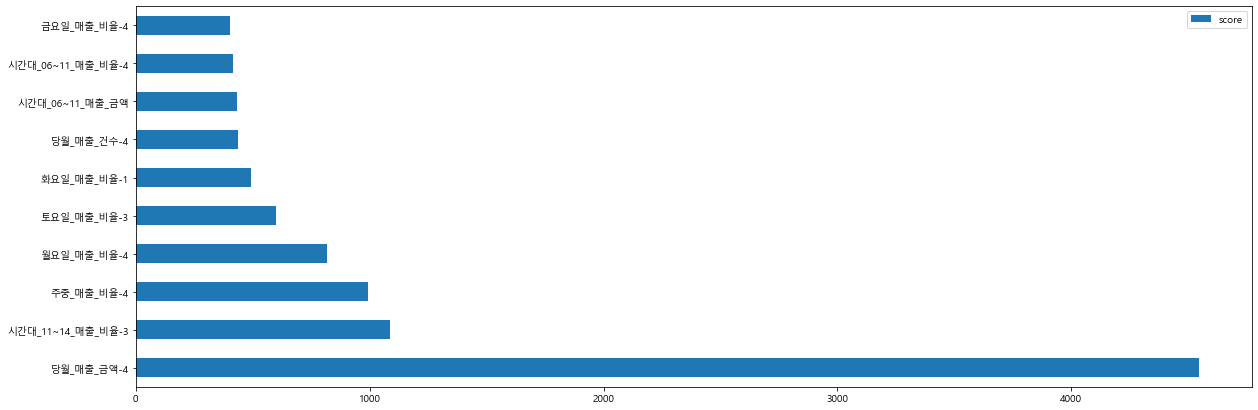

In [189]:
plt.rcParams['font.family'] = 'Malgun Gothic'
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')

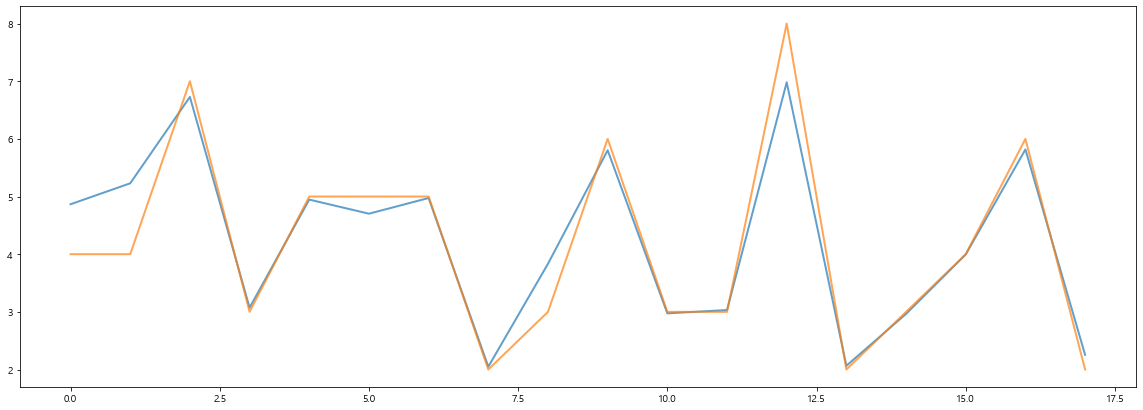

In [190]:
plt.pyplot.plot(model.predict(x_in),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out.values,alpha = 0.7,linewidth = 2)

In [191]:
total=100 #백분율
x_out['폐업_률']=total-x_out['폐업_률']
x_out

,폐업_률
0,96
1,96
2,93
3,97
4,95
5,95
6,95
7,98
8,97
9,94


In [192]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [193]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=6000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:95.41580
[1]	validation_0-rmse:95.32916
[2]	validation_0-rmse:95.24147
[3]	validation_0-rmse:95.15443
[4]	validation_0-rmse:95.06801
[5]	validation_0-rmse:94.98286
[6]	validation_0-rmse:94.89572
[7]	validation_0-rmse:94.81003
[8]	validation_0-rmse:94.72266
[9]	validation_0-rmse:94.63609
[10]	validation_0-rmse:94.55093
[11]	validation_0-rmse:94.46388
[12]	validation_0-rmse:94.37646
[13]	validation_0-rmse:94.29021
[14]	validation_0-rmse:94.20369
[15]	validation_0-rmse:94.11769
[16]	validation_0-rmse:94.03065
[17]	validation_0-rmse:93.94310
[18]	validation_0-rmse:93.85960
[19]	validation_0-rmse:93.77773
[20]	validation_0-rmse:93.69460
[21]	validation_0-rmse:93.61109
[22]	validation_0-rmse:93.52446
[23]	validation_0-rmse:93.44059
[24]	validation_0-rmse:93.35553
[25]	validation_0-rmse:93.27093
[26]	validation_0-rmse:93.18710
[27]	validation_0-rmse:93.10093
[28]	validation_0-rmse:93.01463
[29]	validation_0-rmse:92.93121
[30]	validation_0-rmse:92.84873
[31]	validation_0-

[252]	validation_0-rmse:75.90038
[253]	validation_0-rmse:75.83106
[254]	validation_0-rmse:75.76177
[255]	validation_0-rmse:75.69299
[256]	validation_0-rmse:75.62254
[257]	validation_0-rmse:75.55389
[258]	validation_0-rmse:75.48718
[259]	validation_0-rmse:75.41926
[260]	validation_0-rmse:75.34916
[261]	validation_0-rmse:75.28196
[262]	validation_0-rmse:75.21381
[263]	validation_0-rmse:75.14432
[264]	validation_0-rmse:75.07536
[265]	validation_0-rmse:75.00623
[266]	validation_0-rmse:74.93850
[267]	validation_0-rmse:74.87074
[268]	validation_0-rmse:74.80171
[269]	validation_0-rmse:74.73639
[270]	validation_0-rmse:74.66694
[271]	validation_0-rmse:74.59849
[272]	validation_0-rmse:74.52979
[273]	validation_0-rmse:74.46173
[274]	validation_0-rmse:74.39296
[275]	validation_0-rmse:74.32452
[276]	validation_0-rmse:74.25695
[277]	validation_0-rmse:74.19009
[278]	validation_0-rmse:74.12135
[279]	validation_0-rmse:74.05325
[280]	validation_0-rmse:73.98575
[281]	validation_0-rmse:73.91810
[282]	vali

[501]	validation_0-rmse:60.52526
[502]	validation_0-rmse:60.46979
[503]	validation_0-rmse:60.41444
[504]	validation_0-rmse:60.35907
[505]	validation_0-rmse:60.30338
[506]	validation_0-rmse:60.24921
[507]	validation_0-rmse:60.19559
[508]	validation_0-rmse:60.14151
[509]	validation_0-rmse:60.08721
[510]	validation_0-rmse:60.03250
[511]	validation_0-rmse:59.97821
[512]	validation_0-rmse:59.92387
[513]	validation_0-rmse:59.86949
[514]	validation_0-rmse:59.81553
[515]	validation_0-rmse:59.76152
[516]	validation_0-rmse:59.70621
[517]	validation_0-rmse:59.65157
[518]	validation_0-rmse:59.59697
[519]	validation_0-rmse:59.54260
[520]	validation_0-rmse:59.48811
[521]	validation_0-rmse:59.43321
[522]	validation_0-rmse:59.37848
[523]	validation_0-rmse:59.32593
[524]	validation_0-rmse:59.27121
[525]	validation_0-rmse:59.21807
[526]	validation_0-rmse:59.16499
[527]	validation_0-rmse:59.11015
[528]	validation_0-rmse:59.05541
[529]	validation_0-rmse:59.00170
[530]	validation_0-rmse:58.94852
[531]	vali

[750]	validation_0-rmse:48.26914
[751]	validation_0-rmse:48.22532
[752]	validation_0-rmse:48.18112
[753]	validation_0-rmse:48.13947
[754]	validation_0-rmse:48.09569
[755]	validation_0-rmse:48.05099
[756]	validation_0-rmse:48.00795
[757]	validation_0-rmse:47.96405
[758]	validation_0-rmse:47.91959
[759]	validation_0-rmse:47.87577
[760]	validation_0-rmse:47.83148
[761]	validation_0-rmse:47.78781
[762]	validation_0-rmse:47.74359
[763]	validation_0-rmse:47.70029
[764]	validation_0-rmse:47.65757
[765]	validation_0-rmse:47.61439
[766]	validation_0-rmse:47.57022
[767]	validation_0-rmse:47.52678
[768]	validation_0-rmse:47.48498
[769]	validation_0-rmse:47.44123
[770]	validation_0-rmse:47.39866
[771]	validation_0-rmse:47.35538
[772]	validation_0-rmse:47.31265
[773]	validation_0-rmse:47.26954
[774]	validation_0-rmse:47.22819
[775]	validation_0-rmse:47.18572
[776]	validation_0-rmse:47.14386
[777]	validation_0-rmse:47.10027
[778]	validation_0-rmse:47.05756
[779]	validation_0-rmse:47.01380
[780]	vali

[999]	validation_0-rmse:38.50825
[1000]	validation_0-rmse:38.47326
[1001]	validation_0-rmse:38.43893
[1002]	validation_0-rmse:38.40354
[1003]	validation_0-rmse:38.36810
[1004]	validation_0-rmse:38.33360
[1005]	validation_0-rmse:38.29822
[1006]	validation_0-rmse:38.26296
[1007]	validation_0-rmse:38.22823
[1008]	validation_0-rmse:38.19367
[1009]	validation_0-rmse:38.15900
[1010]	validation_0-rmse:38.12412
[1011]	validation_0-rmse:38.08886
[1012]	validation_0-rmse:38.05454
[1013]	validation_0-rmse:38.01966
[1014]	validation_0-rmse:37.98538
[1015]	validation_0-rmse:37.95161
[1016]	validation_0-rmse:37.91640
[1017]	validation_0-rmse:37.88187
[1018]	validation_0-rmse:37.84781
[1019]	validation_0-rmse:37.81346
[1020]	validation_0-rmse:37.78053
[1021]	validation_0-rmse:37.74665
[1022]	validation_0-rmse:37.71189
[1023]	validation_0-rmse:37.67799
[1024]	validation_0-rmse:37.64345
[1025]	validation_0-rmse:37.61259
[1026]	validation_0-rmse:37.57895
[1027]	validation_0-rmse:37.54704
[1028]	validati

[1240]	validation_0-rmse:30.96157
[1241]	validation_0-rmse:30.93276
[1242]	validation_0-rmse:30.90450
[1243]	validation_0-rmse:30.87610
[1244]	validation_0-rmse:30.84823
[1245]	validation_0-rmse:30.81970
[1246]	validation_0-rmse:30.79145
[1247]	validation_0-rmse:30.76425
[1248]	validation_0-rmse:30.73632
[1249]	validation_0-rmse:30.70857
[1250]	validation_0-rmse:30.68085
[1251]	validation_0-rmse:30.65273
[1252]	validation_0-rmse:30.62492
[1253]	validation_0-rmse:30.59671
[1254]	validation_0-rmse:30.56955
[1255]	validation_0-rmse:30.54163
[1256]	validation_0-rmse:30.51466
[1257]	validation_0-rmse:30.48651
[1258]	validation_0-rmse:30.45919
[1259]	validation_0-rmse:30.43137
[1260]	validation_0-rmse:30.40398
[1261]	validation_0-rmse:30.37691
[1262]	validation_0-rmse:30.34988
[1263]	validation_0-rmse:30.32258
[1264]	validation_0-rmse:30.29656
[1265]	validation_0-rmse:30.26914
[1266]	validation_0-rmse:30.24342
[1267]	validation_0-rmse:30.21640
[1268]	validation_0-rmse:30.18905
[1269]	validat

[1481]	validation_0-rmse:24.92078
[1482]	validation_0-rmse:24.89778
[1483]	validation_0-rmse:24.87561
[1484]	validation_0-rmse:24.85320
[1485]	validation_0-rmse:24.83105
[1486]	validation_0-rmse:24.80904
[1487]	validation_0-rmse:24.78694
[1488]	validation_0-rmse:24.76484
[1489]	validation_0-rmse:24.74253
[1490]	validation_0-rmse:24.72059
[1491]	validation_0-rmse:24.69804
[1492]	validation_0-rmse:24.67512
[1493]	validation_0-rmse:24.65271
[1494]	validation_0-rmse:24.63005
[1495]	validation_0-rmse:24.60757
[1496]	validation_0-rmse:24.58513
[1497]	validation_0-rmse:24.56262
[1498]	validation_0-rmse:24.54020
[1499]	validation_0-rmse:24.51749
[1500]	validation_0-rmse:24.49478
[1501]	validation_0-rmse:24.47326
[1502]	validation_0-rmse:24.45102
[1503]	validation_0-rmse:24.42895
[1504]	validation_0-rmse:24.40694
[1505]	validation_0-rmse:24.38414
[1506]	validation_0-rmse:24.36187
[1507]	validation_0-rmse:24.34046
[1508]	validation_0-rmse:24.31835
[1509]	validation_0-rmse:24.29623
[1510]	validat

[1722]	validation_0-rmse:20.05669
[1723]	validation_0-rmse:20.03933
[1724]	validation_0-rmse:20.02142
[1725]	validation_0-rmse:20.00273
[1726]	validation_0-rmse:19.98425
[1727]	validation_0-rmse:19.96575
[1728]	validation_0-rmse:19.94788
[1729]	validation_0-rmse:19.92963
[1730]	validation_0-rmse:19.91155
[1731]	validation_0-rmse:19.89337
[1732]	validation_0-rmse:19.87526
[1733]	validation_0-rmse:19.85702
[1734]	validation_0-rmse:19.83944
[1735]	validation_0-rmse:19.82206
[1736]	validation_0-rmse:19.80458
[1737]	validation_0-rmse:19.78678
[1738]	validation_0-rmse:19.76882
[1739]	validation_0-rmse:19.75085
[1740]	validation_0-rmse:19.73288
[1741]	validation_0-rmse:19.71523
[1742]	validation_0-rmse:19.69711
[1743]	validation_0-rmse:19.67941
[1744]	validation_0-rmse:19.66122
[1745]	validation_0-rmse:19.64421
[1746]	validation_0-rmse:19.62606
[1747]	validation_0-rmse:19.60814
[1748]	validation_0-rmse:19.59021
[1749]	validation_0-rmse:19.57203
[1750]	validation_0-rmse:19.55416
[1751]	validat

[1963]	validation_0-rmse:16.14765
[1964]	validation_0-rmse:16.13329
[1965]	validation_0-rmse:16.11812
[1966]	validation_0-rmse:16.10434
[1967]	validation_0-rmse:16.08957
[1968]	validation_0-rmse:16.07510
[1969]	validation_0-rmse:16.06156
[1970]	validation_0-rmse:16.04762
[1971]	validation_0-rmse:16.03325
[1972]	validation_0-rmse:16.01925
[1973]	validation_0-rmse:16.00497
[1974]	validation_0-rmse:15.98999
[1975]	validation_0-rmse:15.97528
[1976]	validation_0-rmse:15.96100
[1977]	validation_0-rmse:15.94633
[1978]	validation_0-rmse:15.93263
[1979]	validation_0-rmse:15.91841
[1980]	validation_0-rmse:15.90415
[1981]	validation_0-rmse:15.88977
[1982]	validation_0-rmse:15.87519
[1983]	validation_0-rmse:15.86113
[1984]	validation_0-rmse:15.84667
[1985]	validation_0-rmse:15.83247
[1986]	validation_0-rmse:15.81835
[1987]	validation_0-rmse:15.80444
[1988]	validation_0-rmse:15.79019
[1989]	validation_0-rmse:15.77592
[1990]	validation_0-rmse:15.76205
[1991]	validation_0-rmse:15.74819
[1992]	validat

[2204]	validation_0-rmse:13.01222
[2205]	validation_0-rmse:13.00070
[2206]	validation_0-rmse:12.98919
[2207]	validation_0-rmse:12.97768
[2208]	validation_0-rmse:12.96624
[2209]	validation_0-rmse:12.95446
[2210]	validation_0-rmse:12.94261
[2211]	validation_0-rmse:12.93103
[2212]	validation_0-rmse:12.91934
[2213]	validation_0-rmse:12.90773
[2214]	validation_0-rmse:12.89567
[2215]	validation_0-rmse:12.88425
[2216]	validation_0-rmse:12.87272
[2217]	validation_0-rmse:12.86096
[2218]	validation_0-rmse:12.84954
[2219]	validation_0-rmse:12.83793
[2220]	validation_0-rmse:12.82628
[2221]	validation_0-rmse:12.81473
[2222]	validation_0-rmse:12.80313
[2223]	validation_0-rmse:12.79177
[2224]	validation_0-rmse:12.78063
[2225]	validation_0-rmse:12.76917
[2226]	validation_0-rmse:12.75811
[2227]	validation_0-rmse:12.74695
[2228]	validation_0-rmse:12.73521
[2229]	validation_0-rmse:12.72378
[2230]	validation_0-rmse:12.71226
[2231]	validation_0-rmse:12.70071
[2232]	validation_0-rmse:12.68878
[2233]	validat

[2445]	validation_0-rmse:10.49874
[2446]	validation_0-rmse:10.48935
[2447]	validation_0-rmse:10.48096
[2448]	validation_0-rmse:10.47140
[2449]	validation_0-rmse:10.46202
[2450]	validation_0-rmse:10.45263
[2451]	validation_0-rmse:10.44317
[2452]	validation_0-rmse:10.43372
[2453]	validation_0-rmse:10.42504
[2454]	validation_0-rmse:10.41528
[2455]	validation_0-rmse:10.40635
[2456]	validation_0-rmse:10.39702
[2457]	validation_0-rmse:10.38791
[2458]	validation_0-rmse:10.37814
[2459]	validation_0-rmse:10.36853
[2460]	validation_0-rmse:10.35909
[2461]	validation_0-rmse:10.34966
[2462]	validation_0-rmse:10.34069
[2463]	validation_0-rmse:10.33175
[2464]	validation_0-rmse:10.32272
[2465]	validation_0-rmse:10.31422
[2466]	validation_0-rmse:10.30531
[2467]	validation_0-rmse:10.29592
[2468]	validation_0-rmse:10.28661
[2469]	validation_0-rmse:10.27773
[2470]	validation_0-rmse:10.26877
[2471]	validation_0-rmse:10.25966
[2472]	validation_0-rmse:10.25069
[2473]	validation_0-rmse:10.24165
[2474]	validat

[2692]	validation_0-rmse:8.42798
[2693]	validation_0-rmse:8.42089
[2694]	validation_0-rmse:8.41267
[2695]	validation_0-rmse:8.40569
[2696]	validation_0-rmse:8.39807
[2697]	validation_0-rmse:8.39017
[2698]	validation_0-rmse:8.38296
[2699]	validation_0-rmse:8.37586
[2700]	validation_0-rmse:8.36815
[2701]	validation_0-rmse:8.36024
[2702]	validation_0-rmse:8.35218
[2703]	validation_0-rmse:8.34437
[2704]	validation_0-rmse:8.33723
[2705]	validation_0-rmse:8.32997
[2706]	validation_0-rmse:8.32227
[2707]	validation_0-rmse:8.31510
[2708]	validation_0-rmse:8.30742
[2709]	validation_0-rmse:8.29946
[2710]	validation_0-rmse:8.29223
[2711]	validation_0-rmse:8.28552
[2712]	validation_0-rmse:8.27759
[2713]	validation_0-rmse:8.27299
[2714]	validation_0-rmse:8.26624
[2715]	validation_0-rmse:8.25895
[2716]	validation_0-rmse:8.25136
[2717]	validation_0-rmse:8.24410
[2718]	validation_0-rmse:8.23616
[2719]	validation_0-rmse:8.22950
[2720]	validation_0-rmse:8.22165
[2721]	validation_0-rmse:8.21457
[2722]	val

[2941]	validation_0-rmse:6.83013
[2942]	validation_0-rmse:6.82415
[2943]	validation_0-rmse:6.81854
[2944]	validation_0-rmse:6.81205
[2945]	validation_0-rmse:6.80547
[2946]	validation_0-rmse:6.79996
[2947]	validation_0-rmse:6.79445
[2948]	validation_0-rmse:6.78826
[2949]	validation_0-rmse:6.78246
[2950]	validation_0-rmse:6.77883
[2951]	validation_0-rmse:6.77452
[2952]	validation_0-rmse:6.77097
[2953]	validation_0-rmse:6.76661
[2954]	validation_0-rmse:6.76237
[2955]	validation_0-rmse:6.75564
[2956]	validation_0-rmse:6.75141
[2957]	validation_0-rmse:6.74513
[2958]	validation_0-rmse:6.73875
[2959]	validation_0-rmse:6.73440
[2960]	validation_0-rmse:6.72918
[2961]	validation_0-rmse:6.72516
[2962]	validation_0-rmse:6.71881
[2963]	validation_0-rmse:6.71262
[2964]	validation_0-rmse:6.70622
[2965]	validation_0-rmse:6.70198
[2966]	validation_0-rmse:6.69541
[2967]	validation_0-rmse:6.68951
[2968]	validation_0-rmse:6.68305
[2969]	validation_0-rmse:6.67715
[2970]	validation_0-rmse:6.67089
[2971]	val

[3190]	validation_0-rmse:5.57677
[3191]	validation_0-rmse:5.57326
[3192]	validation_0-rmse:5.56790
[3193]	validation_0-rmse:5.56235
[3194]	validation_0-rmse:5.55889
[3195]	validation_0-rmse:5.55365
[3196]	validation_0-rmse:5.54919
[3197]	validation_0-rmse:5.54362
[3198]	validation_0-rmse:5.54083
[3199]	validation_0-rmse:5.53632
[3200]	validation_0-rmse:5.53161
[3201]	validation_0-rmse:5.52826
[3202]	validation_0-rmse:5.52469
[3203]	validation_0-rmse:5.52098
[3204]	validation_0-rmse:5.51641
[3205]	validation_0-rmse:5.51367
[3206]	validation_0-rmse:5.51089
[3207]	validation_0-rmse:5.50570
[3208]	validation_0-rmse:5.50234
[3209]	validation_0-rmse:5.49870
[3210]	validation_0-rmse:5.49468
[3211]	validation_0-rmse:5.48912
[3212]	validation_0-rmse:5.48549
[3213]	validation_0-rmse:5.48055
[3214]	validation_0-rmse:5.47773
[3215]	validation_0-rmse:5.47416
[3216]	validation_0-rmse:5.46933
[3217]	validation_0-rmse:5.46558
[3218]	validation_0-rmse:5.46213
[3219]	validation_0-rmse:5.45689
[3220]	val

[3439]	validation_0-rmse:4.61814
[3440]	validation_0-rmse:4.61644
[3441]	validation_0-rmse:4.61367
[3442]	validation_0-rmse:4.60972
[3443]	validation_0-rmse:4.60686
[3444]	validation_0-rmse:4.60376
[3445]	validation_0-rmse:4.60016
[3446]	validation_0-rmse:4.59561
[3447]	validation_0-rmse:4.59334
[3448]	validation_0-rmse:4.58923
[3449]	validation_0-rmse:4.58587
[3450]	validation_0-rmse:4.58145
[3451]	validation_0-rmse:4.57804
[3452]	validation_0-rmse:4.57369
[3453]	validation_0-rmse:4.56970
[3454]	validation_0-rmse:4.56697
[3455]	validation_0-rmse:4.56372
[3456]	validation_0-rmse:4.56168
[3457]	validation_0-rmse:4.55936
[3458]	validation_0-rmse:4.55501
[3459]	validation_0-rmse:4.55082
[3460]	validation_0-rmse:4.54663
[3461]	validation_0-rmse:4.54447
[3462]	validation_0-rmse:4.54095
[3463]	validation_0-rmse:4.53738
[3464]	validation_0-rmse:4.53328
[3465]	validation_0-rmse:4.53048
[3466]	validation_0-rmse:4.52581
[3467]	validation_0-rmse:4.52285
[3468]	validation_0-rmse:4.52050
[3469]	val

[3688]	validation_0-rmse:3.87908
[3689]	validation_0-rmse:3.87545
[3690]	validation_0-rmse:3.87283
[3691]	validation_0-rmse:3.87126
[3692]	validation_0-rmse:3.86869
[3693]	validation_0-rmse:3.86492
[3694]	validation_0-rmse:3.86159
[3695]	validation_0-rmse:3.85995
[3696]	validation_0-rmse:3.85841
[3697]	validation_0-rmse:3.85595
[3698]	validation_0-rmse:3.85305
[3699]	validation_0-rmse:3.85027
[3700]	validation_0-rmse:3.84808
[3701]	validation_0-rmse:3.84413
[3702]	validation_0-rmse:3.84219
[3703]	validation_0-rmse:3.84005
[3704]	validation_0-rmse:3.83621
[3705]	validation_0-rmse:3.83513
[3706]	validation_0-rmse:3.83323
[3707]	validation_0-rmse:3.83045
[3708]	validation_0-rmse:3.82855
[3709]	validation_0-rmse:3.82495
[3710]	validation_0-rmse:3.82248
[3711]	validation_0-rmse:3.81959
[3712]	validation_0-rmse:3.81581
[3713]	validation_0-rmse:3.81362
[3714]	validation_0-rmse:3.80979
[3715]	validation_0-rmse:3.80736
[3716]	validation_0-rmse:3.80464
[3717]	validation_0-rmse:3.80095
[3718]	val

[3937]	validation_0-rmse:3.27547
[3938]	validation_0-rmse:3.27425
[3939]	validation_0-rmse:3.27190
[3940]	validation_0-rmse:3.26976
[3941]	validation_0-rmse:3.26778
[3942]	validation_0-rmse:3.26577
[3943]	validation_0-rmse:3.26403
[3944]	validation_0-rmse:3.26173
[3945]	validation_0-rmse:3.25889
[3946]	validation_0-rmse:3.25663
[3947]	validation_0-rmse:3.25360
[3948]	validation_0-rmse:3.25043
[3949]	validation_0-rmse:3.24906
[3950]	validation_0-rmse:3.24709
[3951]	validation_0-rmse:3.24404
[3952]	validation_0-rmse:3.24223
[3953]	validation_0-rmse:3.24030
[3954]	validation_0-rmse:3.23817
[3955]	validation_0-rmse:3.23501
[3956]	validation_0-rmse:3.23365
[3957]	validation_0-rmse:3.23084
[3958]	validation_0-rmse:3.22852
[3959]	validation_0-rmse:3.22543
[3960]	validation_0-rmse:3.22370
[3961]	validation_0-rmse:3.22183
[3962]	validation_0-rmse:3.21861
[3963]	validation_0-rmse:3.21561
[3964]	validation_0-rmse:3.21358
[3965]	validation_0-rmse:3.21046
[3966]	validation_0-rmse:3.20791
[3967]	val

[4186]	validation_0-rmse:2.77820
[4187]	validation_0-rmse:2.77571
[4188]	validation_0-rmse:2.77313
[4189]	validation_0-rmse:2.77173
[4190]	validation_0-rmse:2.77022
[4191]	validation_0-rmse:2.76937
[4192]	validation_0-rmse:2.76781
[4193]	validation_0-rmse:2.76555
[4194]	validation_0-rmse:2.76296
[4195]	validation_0-rmse:2.76037
[4196]	validation_0-rmse:2.75790
[4197]	validation_0-rmse:2.75626
[4198]	validation_0-rmse:2.75477
[4199]	validation_0-rmse:2.75376
[4200]	validation_0-rmse:2.75130
[4201]	validation_0-rmse:2.74995
[4202]	validation_0-rmse:2.74905
[4203]	validation_0-rmse:2.74757
[4204]	validation_0-rmse:2.74529
[4205]	validation_0-rmse:2.74344
[4206]	validation_0-rmse:2.74167
[4207]	validation_0-rmse:2.74013
[4208]	validation_0-rmse:2.73885
[4209]	validation_0-rmse:2.73742
[4210]	validation_0-rmse:2.73606
[4211]	validation_0-rmse:2.73522
[4212]	validation_0-rmse:2.73296
[4213]	validation_0-rmse:2.73112
[4214]	validation_0-rmse:2.72986
[4215]	validation_0-rmse:2.72821
[4216]	val

[4435]	validation_0-rmse:2.40379
[4436]	validation_0-rmse:2.40258
[4437]	validation_0-rmse:2.40081
[4438]	validation_0-rmse:2.39924
[4439]	validation_0-rmse:2.39735
[4440]	validation_0-rmse:2.39666
[4441]	validation_0-rmse:2.39567
[4442]	validation_0-rmse:2.39477
[4443]	validation_0-rmse:2.39281
[4444]	validation_0-rmse:2.39101
[4445]	validation_0-rmse:2.39008
[4446]	validation_0-rmse:2.38922
[4447]	validation_0-rmse:2.38794
[4448]	validation_0-rmse:2.38666
[4449]	validation_0-rmse:2.38465
[4450]	validation_0-rmse:2.38353
[4451]	validation_0-rmse:2.38206
[4452]	validation_0-rmse:2.38073
[4453]	validation_0-rmse:2.38020
[4454]	validation_0-rmse:2.37840
[4455]	validation_0-rmse:2.37719
[4456]	validation_0-rmse:2.37510
[4457]	validation_0-rmse:2.37419
[4458]	validation_0-rmse:2.37320
[4459]	validation_0-rmse:2.37180
[4460]	validation_0-rmse:2.36994
[4461]	validation_0-rmse:2.36938
[4462]	validation_0-rmse:2.36866
[4463]	validation_0-rmse:2.36737
[4464]	validation_0-rmse:2.36607
[4465]	val

[4684]	validation_0-rmse:2.10940
[4685]	validation_0-rmse:2.10840
[4686]	validation_0-rmse:2.10714
[4687]	validation_0-rmse:2.10640
[4688]	validation_0-rmse:2.10512
[4689]	validation_0-rmse:2.10421
[4690]	validation_0-rmse:2.10277
[4691]	validation_0-rmse:2.10217
[4692]	validation_0-rmse:2.10129
[4693]	validation_0-rmse:2.09991
[4694]	validation_0-rmse:2.09898
[4695]	validation_0-rmse:2.09736
[4696]	validation_0-rmse:2.09627
[4697]	validation_0-rmse:2.09555
[4698]	validation_0-rmse:2.09500
[4699]	validation_0-rmse:2.09357
[4700]	validation_0-rmse:2.09300
[4701]	validation_0-rmse:2.09266
[4702]	validation_0-rmse:2.09080
[4703]	validation_0-rmse:2.09049
[4704]	validation_0-rmse:2.08988
[4705]	validation_0-rmse:2.08919
[4706]	validation_0-rmse:2.08887
[4707]	validation_0-rmse:2.08787
[4708]	validation_0-rmse:2.08663
[4709]	validation_0-rmse:2.08536
[4710]	validation_0-rmse:2.08397
[4711]	validation_0-rmse:2.08296
[4712]	validation_0-rmse:2.08223
[4713]	validation_0-rmse:2.08044
[4714]	val

[4933]	validation_0-rmse:1.88348
[4934]	validation_0-rmse:1.88305
[4935]	validation_0-rmse:1.88220
[4936]	validation_0-rmse:1.88113
[4937]	validation_0-rmse:1.88058
[4938]	validation_0-rmse:1.88019
[4939]	validation_0-rmse:1.87977
[4940]	validation_0-rmse:1.87942
[4941]	validation_0-rmse:1.87832
[4942]	validation_0-rmse:1.87706
[4943]	validation_0-rmse:1.87653
[4944]	validation_0-rmse:1.87551
[4945]	validation_0-rmse:1.87512
[4946]	validation_0-rmse:1.87403
[4947]	validation_0-rmse:1.87285
[4948]	validation_0-rmse:1.87201
[4949]	validation_0-rmse:1.87160
[4950]	validation_0-rmse:1.87051
[4951]	validation_0-rmse:1.86944
[4952]	validation_0-rmse:1.86896
[4953]	validation_0-rmse:1.86814
[4954]	validation_0-rmse:1.86733
[4955]	validation_0-rmse:1.86617
[4956]	validation_0-rmse:1.86576
[4957]	validation_0-rmse:1.86470
[4958]	validation_0-rmse:1.86353
[4959]	validation_0-rmse:1.86312
[4960]	validation_0-rmse:1.86169
[4961]	validation_0-rmse:1.86119
[4962]	validation_0-rmse:1.86102
[4963]	val

[5182]	validation_0-rmse:1.69824
[5183]	validation_0-rmse:1.69770
[5184]	validation_0-rmse:1.69682
[5185]	validation_0-rmse:1.69633
[5186]	validation_0-rmse:1.69533
[5187]	validation_0-rmse:1.69423
[5188]	validation_0-rmse:1.69336
[5189]	validation_0-rmse:1.69275
[5190]	validation_0-rmse:1.69260
[5191]	validation_0-rmse:1.69159
[5192]	validation_0-rmse:1.69104
[5193]	validation_0-rmse:1.68986
[5194]	validation_0-rmse:1.68923
[5195]	validation_0-rmse:1.68842
[5196]	validation_0-rmse:1.68742
[5197]	validation_0-rmse:1.68658
[5198]	validation_0-rmse:1.68600
[5199]	validation_0-rmse:1.68544
[5200]	validation_0-rmse:1.68456
[5201]	validation_0-rmse:1.68426
[5202]	validation_0-rmse:1.68376
[5203]	validation_0-rmse:1.68266
[5204]	validation_0-rmse:1.68239
[5205]	validation_0-rmse:1.68163
[5206]	validation_0-rmse:1.68150
[5207]	validation_0-rmse:1.68091
[5208]	validation_0-rmse:1.68080
[5209]	validation_0-rmse:1.68033
[5210]	validation_0-rmse:1.67973
[5211]	validation_0-rmse:1.67891
[5212]	val

[5431]	validation_0-rmse:1.56314
[5432]	validation_0-rmse:1.56311
[5433]	validation_0-rmse:1.56232
[5434]	validation_0-rmse:1.56141
[5435]	validation_0-rmse:1.56054
[5436]	validation_0-rmse:1.56036
[5437]	validation_0-rmse:1.55977
[5438]	validation_0-rmse:1.55947
[5439]	validation_0-rmse:1.55868
[5440]	validation_0-rmse:1.55856
[5441]	validation_0-rmse:1.55811
[5442]	validation_0-rmse:1.55738
[5443]	validation_0-rmse:1.55656
[5444]	validation_0-rmse:1.55575
[5445]	validation_0-rmse:1.55517
[5446]	validation_0-rmse:1.55431
[5447]	validation_0-rmse:1.55372
[5448]	validation_0-rmse:1.55342
[5449]	validation_0-rmse:1.55251
[5450]	validation_0-rmse:1.55234
[5451]	validation_0-rmse:1.55211
[5452]	validation_0-rmse:1.55119
[5453]	validation_0-rmse:1.55087
[5454]	validation_0-rmse:1.55039
[5455]	validation_0-rmse:1.54980
[5456]	validation_0-rmse:1.54945
[5457]	validation_0-rmse:1.54866
[5458]	validation_0-rmse:1.54813
[5459]	validation_0-rmse:1.54761
[5460]	validation_0-rmse:1.54655
[5461]	val

[5680]	validation_0-rmse:1.44043
[5681]	validation_0-rmse:1.43979
[5682]	validation_0-rmse:1.43918
[5683]	validation_0-rmse:1.43845
[5684]	validation_0-rmse:1.43813
[5685]	validation_0-rmse:1.43782
[5686]	validation_0-rmse:1.43745
[5687]	validation_0-rmse:1.43712
[5688]	validation_0-rmse:1.43655
[5689]	validation_0-rmse:1.43556
[5690]	validation_0-rmse:1.43484
[5691]	validation_0-rmse:1.43481
[5692]	validation_0-rmse:1.43415
[5693]	validation_0-rmse:1.43337
[5694]	validation_0-rmse:1.43302
[5695]	validation_0-rmse:1.43286
[5696]	validation_0-rmse:1.43272
[5697]	validation_0-rmse:1.43243
[5698]	validation_0-rmse:1.43230
[5699]	validation_0-rmse:1.43158
[5700]	validation_0-rmse:1.43122
[5701]	validation_0-rmse:1.43055
[5702]	validation_0-rmse:1.43001
[5703]	validation_0-rmse:1.42964
[5704]	validation_0-rmse:1.42958
[5705]	validation_0-rmse:1.42903
[5706]	validation_0-rmse:1.42886
[5707]	validation_0-rmse:1.42854
[5708]	validation_0-rmse:1.42796
[5709]	validation_0-rmse:1.42746
[5710]	val

[5929]	validation_0-rmse:1.35718
[5930]	validation_0-rmse:1.35669
[5931]	validation_0-rmse:1.35657
[5932]	validation_0-rmse:1.35607
[5933]	validation_0-rmse:1.35530
[5934]	validation_0-rmse:1.35504
[5935]	validation_0-rmse:1.35465
[5936]	validation_0-rmse:1.35416
[5937]	validation_0-rmse:1.35408
[5938]	validation_0-rmse:1.35396
[5939]	validation_0-rmse:1.35394
[5940]	validation_0-rmse:1.35327
[5941]	validation_0-rmse:1.35332
[5942]	validation_0-rmse:1.35326
[5943]	validation_0-rmse:1.35249
[5944]	validation_0-rmse:1.35251
[5945]	validation_0-rmse:1.35222
[5946]	validation_0-rmse:1.35145
[5947]	validation_0-rmse:1.35145
[5948]	validation_0-rmse:1.35078
[5949]	validation_0-rmse:1.35070
[5950]	validation_0-rmse:1.35003
[5951]	validation_0-rmse:1.35001
[5952]	validation_0-rmse:1.34972
[5953]	validation_0-rmse:1.34969
[5954]	validation_0-rmse:1.34893
[5955]	validation_0-rmse:1.34833
[5956]	validation_0-rmse:1.34767
[5957]	validation_0-rmse:1.34742
[5958]	validation_0-rmse:1.34675
[5959]	val

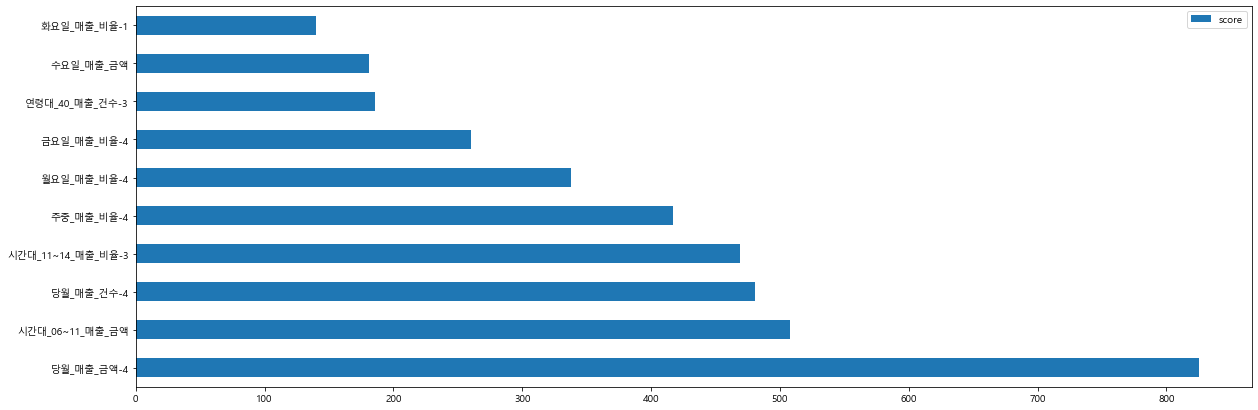

In [197]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')